In [11]:
import warnings
import numpy as np
import pandas as pd
from Data import Data
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries")

# First we run the Data Object to recieve the results of the Data Pipeline

In [12]:
# Initialize the Data class with the participants DataFrame
data_processor = Data()
data_processor.get_subject_file_pairs()
data_processor.process_all_subjects()

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


## Then the data is processed to run a linear regression and find the P values

In [16]:
df = data_processor.participants_df
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2

# Drop irrelevant columns
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])
columns_to_exclude = [
        'gender', 'avg cudit', 'cudit total baseline', 'cudit total follow-up',
        'audit total baseline', 'audit total follow-up', 'participant_id',
        'group', 'age at onset first CB use', 'age at onset frequent CB use','age at baseline']

# Encode categorical columns and drop unnecessary columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes
    
X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')
y = df_encoded['avg cudit']

# Impute missing values with the mean
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Feature', 'MSE', 'R²', 'P-value'])

# Perform linear regression for each feature with significance testing
for feature in X_imputed.columns:
    # Prepare single feature for regression
    X_feature = X_imputed[[feature]]
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Use statsmodels for significance testing
    X_feature_with_const = sm.add_constant(X_feature)  # Add intercept
    ols_model = sm.OLS(y, X_feature_with_const).fit()
    if len(ols_model.pvalues) > 1:  # Ensure the p-value for the feature exists
        p_value = ols_model.pvalues.iloc[1]
    else:
        p_value = np.nan
    new_row = pd.DataFrame({'Feature': [feature], 'MSE': [mse], 'R²': [r2], 'P-value': [p_value]})
    # Check if the new_row is valid before concatenating
    if not new_row.isna().all(axis=None) and not new_row.empty:
        results = pd.concat([results, new_row], ignore_index=True)

# Sort the results by R² in descending order
results = results.sort_values(by='R²', ascending=False)
# Display the results
print("Linear Regression Results with Significance Testing:")
print(results.head(10))
# Save results to Excel if needed
results.to_excel('linear_regression_with_significance.xlsx', index=False)

Linear Regression Results with Significance Testing:
                                               Feature        MSE        R²  \
40   Inferior Temporal Gyrus, anterior division Vol...  35.173638  0.487763   
109  Temporal Fusiform Cortex, anterior division Vo...  35.173638  0.487763   
73                    Frontal Medial Cortex Volume Avg  53.753582  0.217181   
114  Temporal Fusiform Cortex, posterior division C...  54.957521  0.199648   
54                     Superior Parietal Lobule Change  62.407969  0.091146   
45   Inferior Temporal Gyrus, posterior division Ch...  62.425975  0.090884   
15    Inferior Frontal Gyrus, pars triangularis Change  62.476664  0.090146   
105   Parahippocampal Gyrus, posterior division Change  63.515716  0.075014   
57       Supramarginal Gyrus, anterior division Change  64.080295  0.066792   
48   Inferior Temporal Gyrus, temporooccipital part...  64.453544  0.061356   

      P-value  
40   0.012803  
109  0.012803  
73   0.066673  
114  0.019487

/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_25799/827856003.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


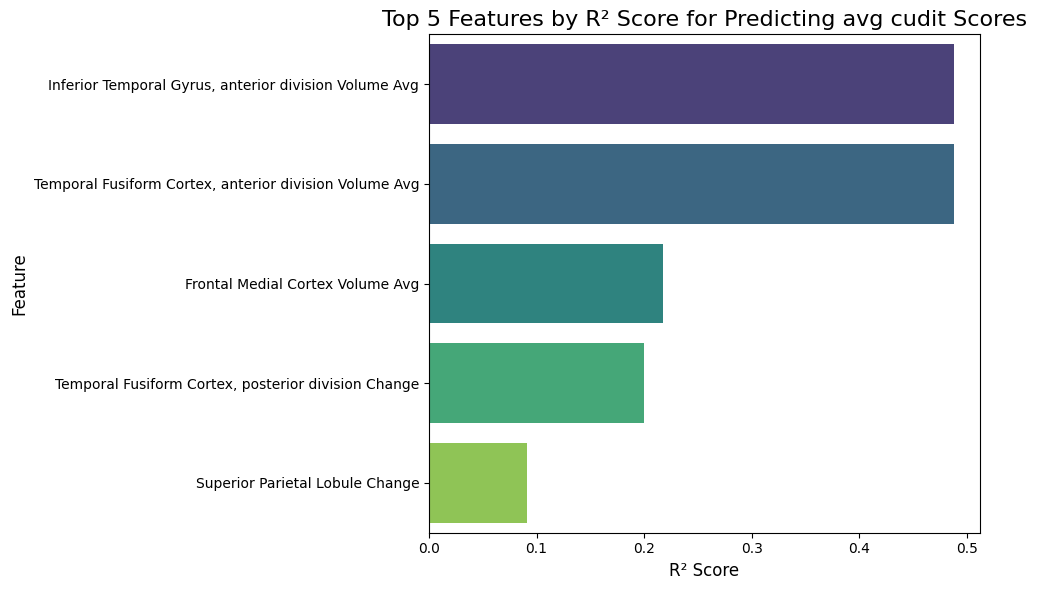

In [17]:
# Assuming 'results' DataFrame is already loaded and sorted by R² in descending order
# Select the top 5 features by R²
top_5_results = results.head(5)

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_5_results['R²'], 
    y=top_5_results['Feature'], 
    palette='viridis'
)

# Add title and labels
plt.title('Top 5 Features by R² Score for Predicting avg cudit Scores', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()